# CAP 6618 - Machine Learning for Computer Vision

Christian Garbin
Spring 2019

# Programming Project 3

In [2]:
######################
####
####   TODO:
####      1. Run from start again
####      2. Update all findings and pics
####
#####################

## Starting point

In the experimental notebook we trained a network that achieved 99.13% accuracy on the training set.

In this notebook we will attempt to improve it using these techniques:

- More layers
- Batch normalization
- Image augmentation

## Current state of the art

According to [this site](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html), the best MNIST accuracy has 0.21% error rate, i.e 99.79% accuracy.

According to [LeCun's MNIST page](http://yann.lecun.com/exdb/mnist/), the best accuracy has an error rate of 0.23% (99.77% accuracy). To achieve that a "committee of 35 conv. net, 1-20-P-40-P-150-10 [elastic distortions]" was used.

Therefore, that's the maximum can we hope to achieve in these experiments.

# Step 1: Setup

First, make sure that you have installed Keras on your computer.

In [3]:
# Code from https://github.com/keras-team/keras 

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import Adadelta
from keras import backend as K

/var/web_services/galaxy/jupyter_conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

## Step 1a: Auxiliary functions and constants

Some data manipulation and visualization functions.

Visualize Keras training accuracy and loss, given a `History` object collected from calling `fit()`.

In [5]:
# Adapted from https://keras.io/visualization/ - changed to side-by-side plots to save space
from matplotlib.ticker import MaxNLocator

def plot_keras_history(history):

    # Side-by-side plots, wider than taller, to make run for the epochs
    f = plt.figure(figsize=(12,4))
    ax_acc = f.add_subplot(121)
    ax_loss = f.add_subplot(122)

    # Plot training & validation accuracy values
    ax_acc.plot(history.history['acc'])
    ax_acc.plot(history.history['val_acc'])
    ax_acc.set_title('Model accuracy')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_xlabel('Epoch')
    ax_acc.legend(['Train', 'Test'], loc='upper left')
    ax_acc.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot training & validation loss values
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_title('Model loss')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_xlabel('Epoch')
    ax_loss.legend(['Train', 'Test'], loc='upper left')
    ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

Train a model, validate on test data and show training loss/accuracy in graphical format.

In [6]:
"""Train a model, validate on test data, show training loss/accuracy in graphical format, save trained model.

Parameters:
   model_generator (function): the function that creates the Keras model to be trained.
   file_name (string): name of the file to save the trained model, or None to not save it.
   batch_size (int): batch size for training.
   epochs (int): maximum number of epochs to train.
   verbose (int): Keras' verbosity level.
   callbacks (array): Keras' callbacks to use during training.

Returns:
   The trained model and ah .h5 file on the local directory with the trained model, if a file name was given.
   
Note: assumes that train and test data are set in global variables (see code).
"""
def train_validate_analyze(model_generator, description, batch_size, epochs, verbose=1, callbacks=None):
    model = model_generator()
    model.summary()
    
    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=verbose,
          callbacks=callbacks,
          validation_data=(x_test, y_test))
    
    if description is not None:
        model.save(description + '.h5')

    score = model.evaluate(x_test, y_test, verbose=verbose)
    print('Test loss:', score[0]) 
    print('Test accuracy:', score[1])
    
    plot_keras_history(history)    
    
    return model

Number of classes in the MNIST dataset.

In [7]:
NUM_CLASSES = 10

# Step 2: Load, split and prepare the MNIST dataset

In [8]:
# Code from https://github.com/keras-team/keras 

# Re-load and re-shape the dataset

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Save original data to show images later
original_x_test = x_test

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Step 4: Baseline

This is the same network from the experimental notebook, repeated here to have a baseline.

In [9]:
def get_baseline_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

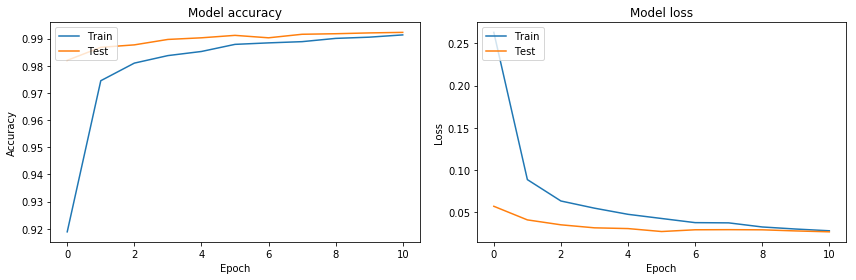

In [10]:
model_baseline = train_validate_analyze(get_baseline_model, 'baseline', batch_size=128, epochs=11)

# Step 5: Add more pooling and dense layers

## Step 5a: LeNet-5-like network

This network adds convolutional and polling layers. It was chosen for a historical reason: it is very close to the [LeNet-5 architecture](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).

"Very close" because this network uses an adaptive optimizer, while LeNet used SGD (I think, not 100% sure - could not find a good reference, but since it is from the later 1990s, it is likely to be using SGD). 

Another difference is the image size. LeNet used 32x32 images, while we use 28x28 images. To compensate for that, the first convolutional layer uses `same` padding.

LeNet-5 [achieved 99.05% accuracy](http://yann.lecun.com/exdb/mnist/) without manipulating images.

In [11]:
# based on https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9

# Compare with structure in the book:
# Input 32x32 (28x28 padded)
# Convolution 6 28x28 5x5 tanh
# AvgPooling 6 14x14 2x2 
# Convolution 16 10x10 5x5 tanh
# AvgPooling 16 5x5 2x2
# Convolution 120 1x1 5x5 tanh
# Fully connected 84 tanh
# Fully connected 10 RBF


def get_lenet_like_model():
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(Flatten())
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(units=NUM_CLASSES, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    return model


In the first attempt we will train for the same number of epochs used for the baseline network.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 84)                10164     
__________

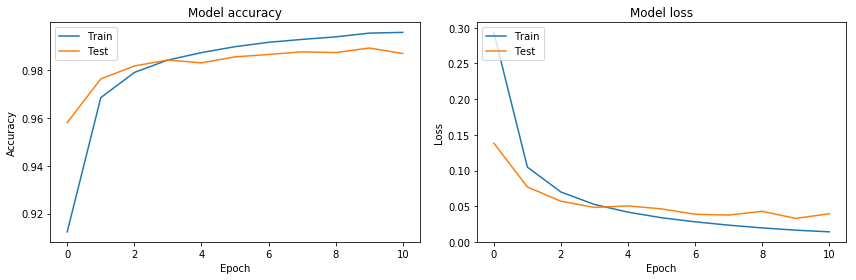

In [12]:
model_lenet_like = train_validate_analyze(get_lenet_like_model, 'lenet-like', batch_size=128, epochs=11)

This is a decent result for a relatively small network (small number of parameters). It is close to the result reported in LeCun's paper.

The graphs shows that it is overfitting at around epochs 5 and 7 (exact epoch wil vary by run). Before we completely give up on it, we will try to deal with the overfitting.

### Deal with overfitting - add dropout

To try to get more accuracy out of this network we will add dropout layers to fight overfitting.

In [13]:
# based on https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9

DROPOUT_RATE_CONV = 0.25
DROPOUT_RATE_DENSE = 0.5

def get_lenet_like_model_with_dropout():
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Dropout(DROPOUT_RATE_CONV))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Dropout(DROPOUT_RATE_CONV))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(Dropout(DROPOUT_RATE_CONV))
    model.add(Flatten())
    model.add(Dense(84, activation='tanh'))
    model.add(Dropout(DROPOUT_RATE_DENSE))
    model.add(Dense(units=NUM_CLASSES, activation='softmax'))    
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_3 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_4 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 120)         48120     
__________

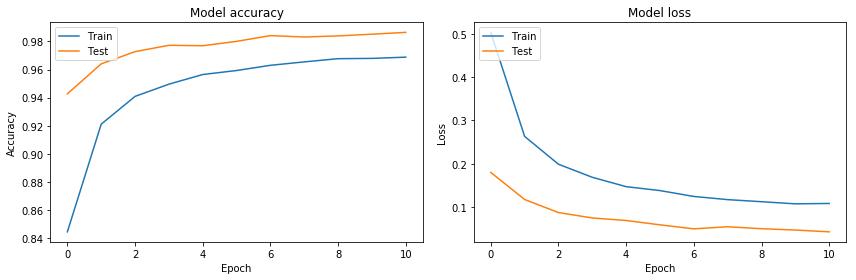

In [14]:
model_lenet_like_with_dropout = train_validate_analyze(get_lenet_like_model_with_dropout, 'lenet-like-with-dropout', batch_size=128, epochs=11)

It is no longer overfitting. It is now underfitting.

Since it is not overfitting we will push it further with more epochs, before we give up on it.

### Deal with overfitting - train longer, with early stopping

Now that we are not overfitting we can train for more epochs.

However, we don't know how many epochs ahead of time. We will use Keras' [`EarlyStopping` callback](https://keras.io/callbacks/#earlystopping) to decide when to stop.

With early stopping in place we can use a high number of epochs and rely on the `EarlyStopping` callback to decide when to stop.

In [15]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=2)]
# Keras 2.2.3 has a new parameter: restore_best_weights. It would improve results a bit.
# FAU HPC is running Keras 2.1.x

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_5 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_6 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 120)         48120     
__________

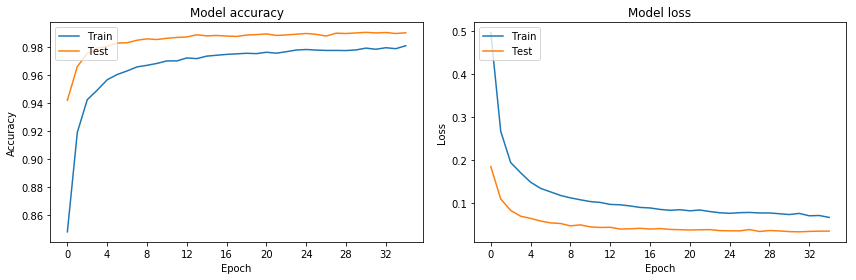

In [16]:
model_lenet_like_dropout_early_stopping = train_validate_analyze(get_lenet_like_model_with_dropout,
                                                         'lenet-like-with-dropout-early-stopping', batch_size=128,
                                                         epochs=100, verbose=2, callbacks=callbacks) 

TODO: analysis here

### Deal with overfitting - switch to batch normalization

TODO: add text here

In [24]:
# based on https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9

def get_lenet_like_model_with_batch_normalization(activation='tanh'):
    model = Sequential()

    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation=activation,
                     input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation=activation, padding='valid'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation=activation, padding='valid'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(84, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(units=NUM_CLASSES, activation='softmax'))    
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
average_pooling2d_13 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
average_pooling2d_14 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 1, 120)         48120     
__________

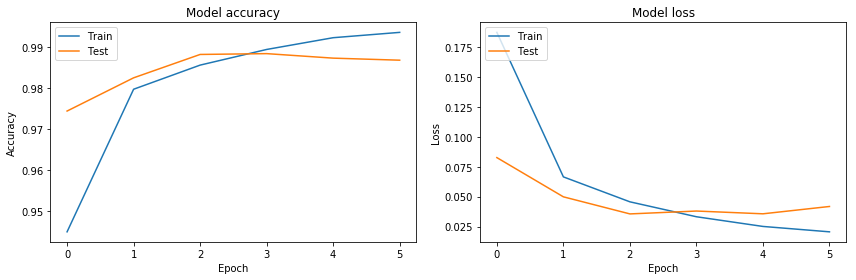

In [25]:
model_lenet_like_batch_norm_early_stopping = train_validate_analyze(get_lenet_like_model_with_batch_normalization,
                                                         'lenet-like-with-batch-normalization-early-stopping',
                                                         batch_size=128, epochs=100, verbose=2, callbacks=callbacks) 

TODO: add analysis here

### Deal with overfitting - modernize the network (<<< add details)

TODO: explain changes and reasoning

In [31]:
def lenet_relu():
    return get_lenet_like_model_with_batch_normalization(activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
average_pooling2d_15 (Averag (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_18 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
average_pooling2d_16 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 1, 1, 120)         48120     
__________

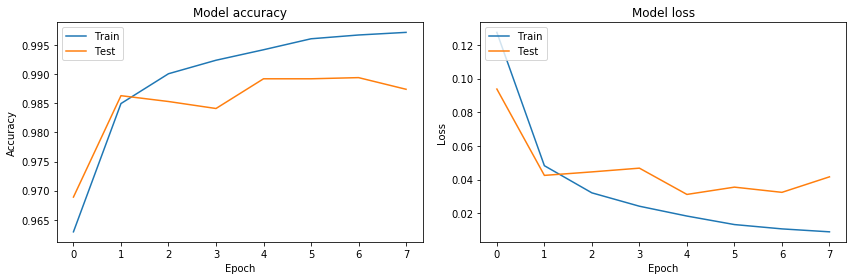

In [32]:
model_lenet_model_modernized = train_validate_analyze(lenet_relu,
                                                         'lenet-like-modernized',
                                                         batch_size=128, epochs=100, verbose=2, callbacks=callbacks) 

## Step 5b: VGG-like network

In this section we will attempt a network topology similar to the VGG network: a series of convolution layers with the same filter size, with pooling layers in between, followed by large dense layers.

The distinguishing feature of this network is the repetition of the same 3 x 3 filter in all convolution layers, followed by a series of (rather large) dense layers at the very end. Half of the size of the network comes from these dense layers.

In [18]:
# based on https://medium.com/@amir_hf8/implementing-vgg13-for-mnist-dataset-in-tensorflow-abc1460e2b93

def get_vgg_like_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape, padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Flatten())
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dense(units=1000, activation='relu'))
    model.add(Dense(units=NUM_CLASSES, activation = 'softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    
    return model

Train with early stopping.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 256)         295168    
__________

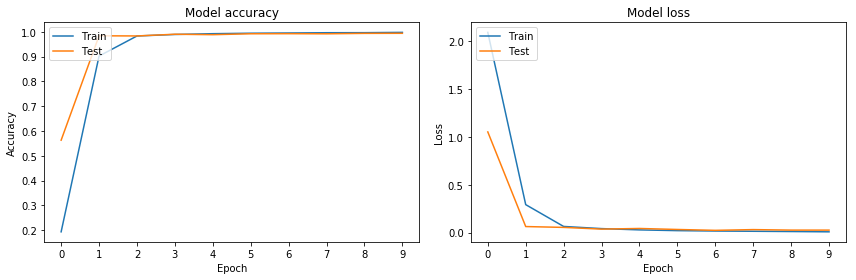

In [19]:
model_vgg_like = train_validate_analyze(get_vgg_like_model, 'vgg-like', batch_size=128,
                                        epochs=100, verbose=2,callbacks=callbacks) 

TODO: Analysis

# Step 6: Select the best model

The table below shows the results from the tests (these number will vary from one run to another, but should stay in the same vicinity).

| Network | Accuracy  (%) | Time to test one epoch (s) | Epochs to converge | Number of parameters | Size of model (.h5) file (MB) |
|---------|--------------:|---------------------------:|-------------------:|---------------------:|------------------------------:|
| Baseline                                   | 99.11 | 10 |  11 |  1,199,882 |   14.4 |
| LeNet like                                 | 98.95 |  5 |   7 |     64,078 |    0.8 |
| LeNet like with dropout                    | 98.50 |  6 | N/A |     64,078 |    0.8 |
| LeNet like with dropout and early stopping | 99.12 |  5 |  28 |     64,078 |    0.8 |
| VGG like                                   | 99.27 | 74 |   8 | 32,393,410 |  388.8 |

The best network by accuracy is the VGG-like one. However, it is significantly slower to train (each epoch) and uses by far the largest amount of memory. It is not very efficient for this task.

The baseline network and the regularized LeNet network with early stopping have similar accuracy. However, the LeNet network is faster to train (each epoch) and uses almost nineteen times less memory.

Combining accuracy and efficient use of memory makes the regularized LeNet with early stopping the best network in this set.

Therefore it will be picked as the best overall (and also because it is nice to have a chance to play with this historical network...).

# Step 7: Analyze the best model

In [15]:
# If running the notebook in one go, get rid of the largest mode to release some memory
# May not make a large difference for well-configured computers, but it's simple to do and can help a bit
del model_vgg_like

NameError: name 'model_vgg_like' is not defined

## Step 7a: Restore the model

Because of the long run times, it is likely that we had to stop notebook at one point.

Load the best model from the disk to continue with this section.

In [16]:
from keras.models import load_model
model = load_model('lenet-like-with-batch-normalization-early-stopping.h5')

## Step 7a: Visualize the model

In [17]:
# Requires pydot and graphviz - will **NOT** work in FAU's HPC as of March/2019
#  pip install pydot
#  pit install graphviz

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Sizing code from https://stackoverflow.com/a/54965459
dot_model = model_to_dot(model, show_layer_names=False, show_shapes=True)
dot_model.set_size('6x4') # size in inches
SVG(dot_model.create(prog='dot', format='svg'))

"dot" with args ['-Tps', '/tmp/tmpk1nr75zo'] returned code: 1

stdout, stderr:
 b''
b'Error: /usr/lib64/graphviz/config6 is zero sized, or other read error.\nError: /usr/lib64/graphviz/config6 is zero sized, or other read error.\nFormat: "ps" not recognized. Use one of:\n'



ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

## Step 7b: Analyze errors

### Predictions

Get predictions from the model in probabilities and classes.

In [18]:
import numpy as np

predicted_probability = model.predict(x_test)
predicted_class = np.argmax(predicted_probability, axis=1)

The actual class labels, converted from the hot-encoded labels.

In [19]:
actual_class_label = np.argmax(y_test, axis=1)

### Confusion matrix

Confusion matrix reminder:

* Rows are actual class
* Columns are predicted class

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

conf_mx = confusion_matrix(actual_class_label, predicted_class)
print(conf_mx)

[[ 976    1    1    0    0    0    0    0    2    0]
 [   0 1130    3    0    0    0    1    1    0    0]
 [   0    0 1030    0    1    0    0    0    1    0]
 [   0    0    2 1001    0    3    0    1    2    1]
 [   0    0    2    0  970    0    2    0    0    8]
 [   1    0    0    3    0  884    2    1    0    1]
 [   1    1    1    0    2    2  951    0    0    0]
 [   1    1   11    1    1    0    0 1010    2    1]
 [   1    0    3    2    0    2    0    0  964    2]
 [   2    0    0    1    1    0    0    1    6  998]]


### Where confusion happen

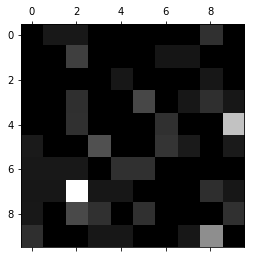

In [21]:
# Adapted from Géron's notebooks 

# Normalize each row so one class doesn't dominate the values, skewing the heatmap
# This is not strictly necessary in this case because MNIST classes are well-balanced
# It's good practice nevertheless
row_sums = conf_mx.sum(axis=1, keepdims=True)
conf_mx_misclassifications = conf_mx / row_sums

# Remove correct classifications (leaves only misclassifications in the matrix)
np.fill_diagonal(conf_mx_misclassifications, 0)  

plt.matshow(conf_mx_misclassifications, cmap=plt.cm.gray)
plt.show()

**NOTE**: Results will vary from one run to another. Analysis of specific instances in the text below may change. Whenever applicable, the text explains the reason for the conclusions, so they can be updated when newer runs produce different results (the results will change, but the reasoning for the analysis will not).

The brighest spots in the matrix indicate the highest areas of confusion.

* When wrongly predicted, 5s are more frequently confused with 3.
* Same for 7s confused with 2.
* Same for 9s confused with 4.

### Misclassification and confusion count by digit

Visualize what digits have higher misclassifcation and confusion count.

Misclassification counts the rows in the confunsion matrix. Confusion counts the columns.

Number of misclassified digits: 86


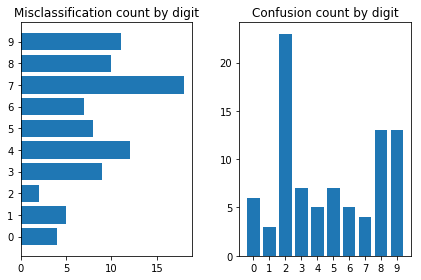

In [22]:
# A confusion matrix with misclassified digits only
conf_mx_misclassifications = conf_mx
np.fill_diagonal(conf_mx_misclassifications, 0) 

print('Number of misclassified digits: {}'.format(sum(conf_mx_misclassifications.sum(axis=0))))

misclassification_count_by_digit = conf_mx_misclassifications.sum(axis=1)
confusion_count_by_digit = conf_mx_misclassifications.sum(axis=0)

ax = plt.subplot(1, 2, 1)
plt.barh(np.arange(len(misclassification_count_by_digit)),misclassification_count_by_digit)
ax.set_title('Misclassification count by digit')
ax.set_yticks(np.arange(NUM_CLASSES))

ax = plt.subplot(1, 2, 2)
plt.bar(np.arange(len(confusion_count_by_digit)),confusion_count_by_digit)
ax.set_title('Confusion count by digit')
ax.set_xticks(np.arange(NUM_CLASSES))

plt.tight_layout()
plt.show()

TODO: review this: From the graphs above we can see that:

* Longest horizontal bar (sum of rows): 9 is most misclassified digit - it is a 9, but was predicted as another digit.
* Longest vertical bar (sum of columns): 2 is the most confused with digit - it is another digit, but was confused with a 2.

## Misclassified instances

Show all misclassified digits, the network predicted for that digit and how sure (or not) the network was of that prediction (a histogram of the class probabilities).

The vertical number next to each digit is the index into the test dataset, so we can inspect individual instances, if needed.

First, a few functions to help plot the information.

In [23]:
"""Draw the image of a digit, given its index into an array of images.
"""
def draw_one_digit(ax, digit_index, digit_images, title=None):
    # Remove the box around the number
    ax.axis('off')
    # Draw the number on an inverted gray scale, so it looks like it was written by a person
    ax.imshow(digit_images[digit_index], cmap=plt.get_cmap('gray_r'))
    # Show the predicted class at the top
    ax.set_title(title)
    # Show the index in the test dataset on the left side, rotated to save space on multiple plots
    ax.text(0, 0, digit_index, rotation=90)

In [24]:
from matplotlib.ticker import NullFormatter

"""Draw a histogram of the predicted probabilities for each class and format for easier reading.
"""
def draw_prediction_histogram(ax, class_probabilities, hide_y_labels):
    classes = np.arange(NUM_CLASSES)
    
    # Show all graphs in the same scale, to allow comparison
    ax.set_ylim(0, 100)

    # Draw the bars and show the class (digit) above each one
    bars = ax.bar(classes, class_probabilities*100) # Show in % (nicer labels for the y axis)
    for digit, bar in zip(classes, bars):
        yval = bar.get_height()
        ax.text(bar.get_x() - 0.25, yval + 3, digit)

    # Remove all tick marks, the bottom labels (already show class above the bar) and suppress
    # the y label for zero on the left corner to avoid confusion with the class - also zero
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks([])
    ax.set_yticks([25, 50, 75, 100])
    
    # Hide the y axis label if so requested (to make it look cleaner, show y labels only for
    # the first graph [left] in the row)
    if hide_y_labels:
        ax.yaxis.set_major_formatter(NullFormatter())

    # Show faint grid lines behind the bars
    ax.yaxis.grid(color='grey', alpha=0.25)
    ax.set_axisbelow(True)
    
    # Leave only the bottom spine visible, so the bars aren't "floating in space"
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [25]:
# Inspired by https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e
import math

""" Draw misclassified digits selected from the test dataset, given their indices.
Assumes that arrays with predicted classes and predicted probabilities have already
been populated elsewhere (usually when showing a confusion matrix).
"""
def draw_digits(digit_indices):
    number_of_digits = len(digit_indices)
    num_cols = 10
    num_rows = math.ceil(number_of_digits / num_cols)

    # Subplots with twice as many rows as we calculated above because we will show a histogram
    # of the predictions below each digit. The histogram is twice as tall as the digit (the
    # gridspec_kw values).
    f, ax = plt.subplots(num_rows*2, num_cols, figsize=(15, 4*num_rows),
                         gridspec_kw = {'height_ratios':np.tile([1,2], num_rows)})

    for r in range(num_rows):
        for c in range(num_cols):
            image_index = r * num_cols + c
            if image_index < number_of_digits:
                digit_index = digit_indices[image_index]
                title = "Pred. {}".format(predicted_class[digit_index])
                draw_one_digit(ax[r*2,c], digit_index, original_x_test, title)
                draw_prediction_histogram(ax[r*2+1,c], predicted_probability[digit_index], c > 0)
            else:
                # Turn off the spines to show an empty space in incomplete rows
                ax[r*2,c].axis('off')
                ax[r*2+1,c].axis('off')

    plt.tight_layout()
    plt.show()

Found 86 misclassified instances


Misclassified 0s


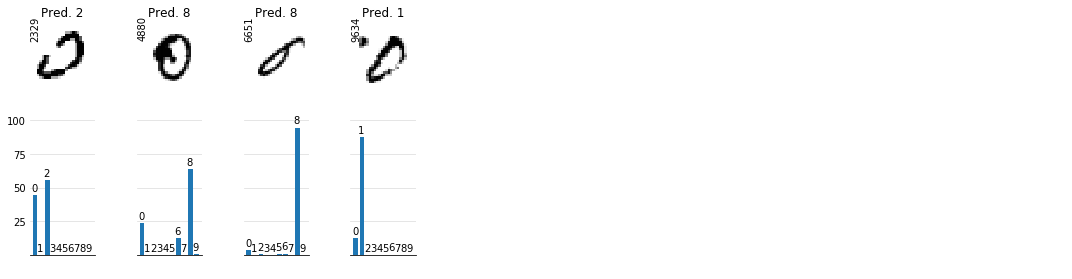



Misclassified 1s


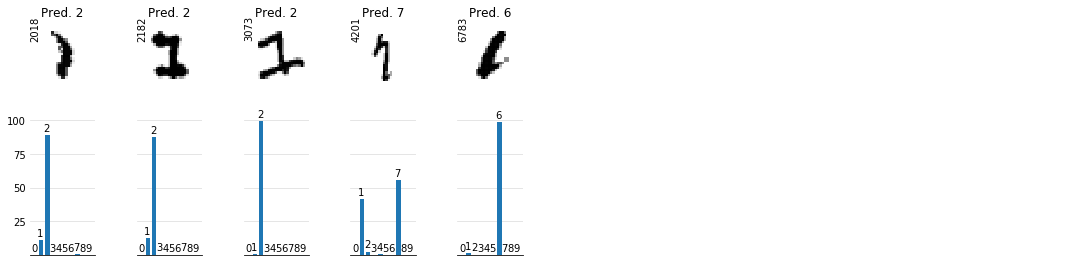



Misclassified 2s


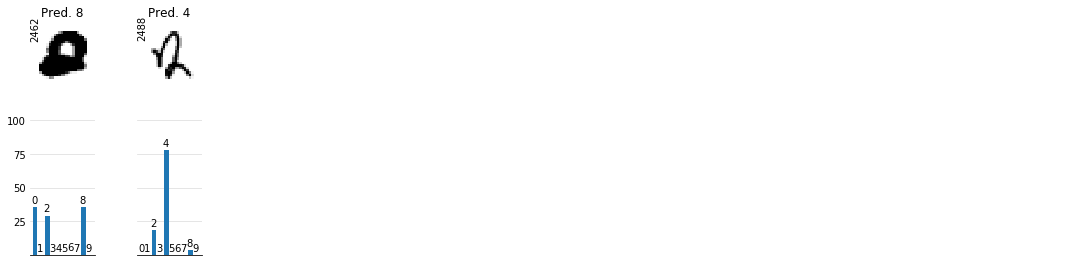



Misclassified 3s


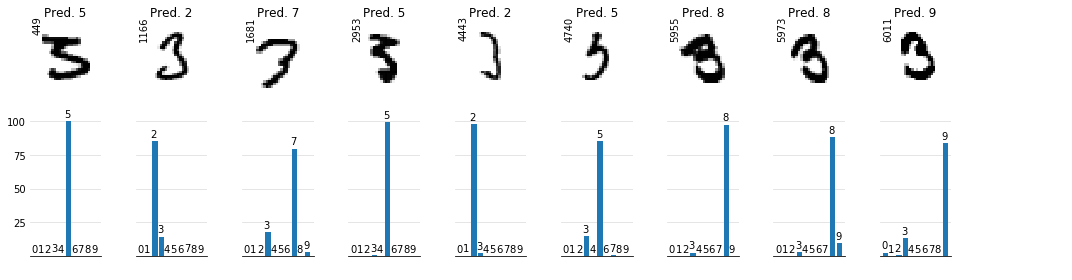



Misclassified 4s


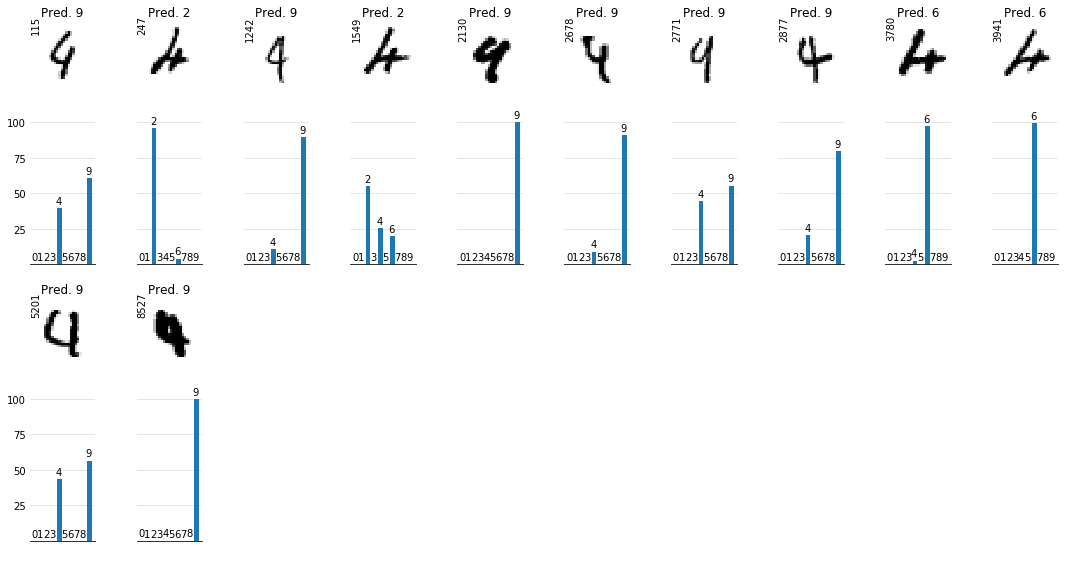



Misclassified 5s


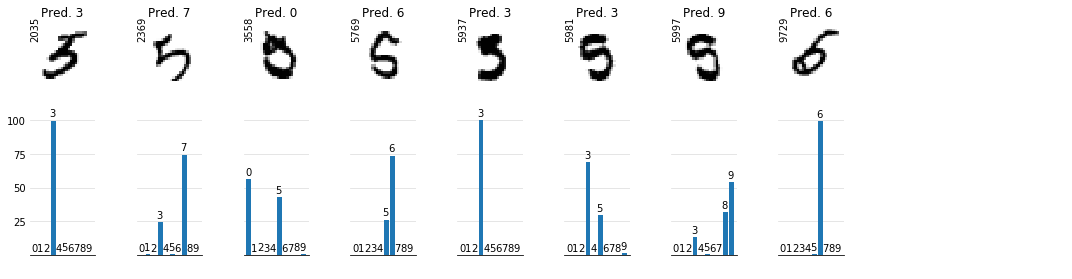



Misclassified 6s


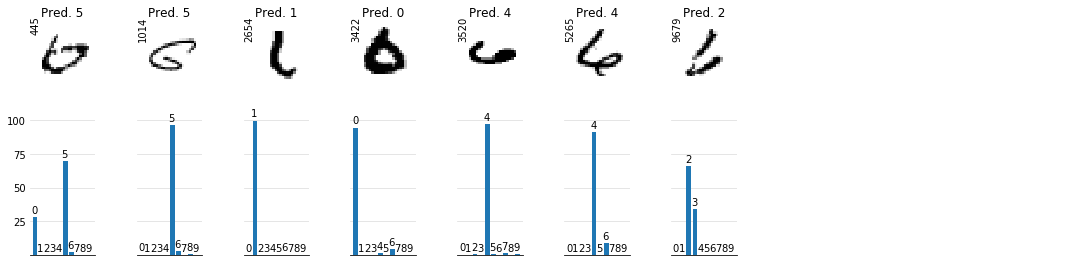



Misclassified 7s


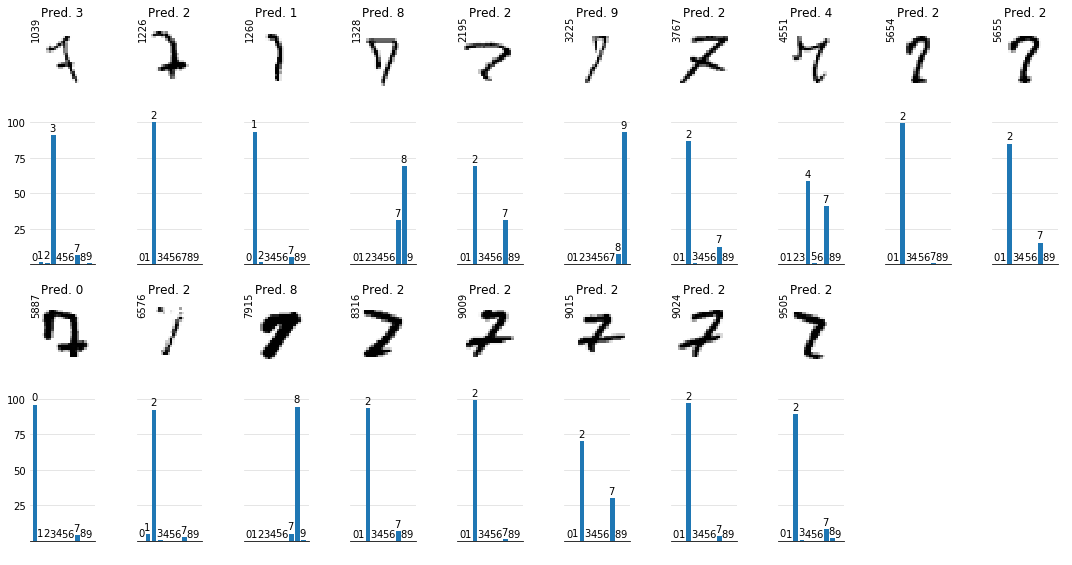



Misclassified 8s


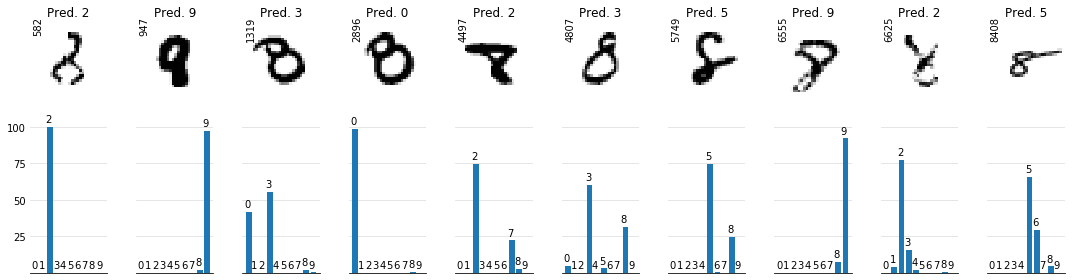



Misclassified 9s


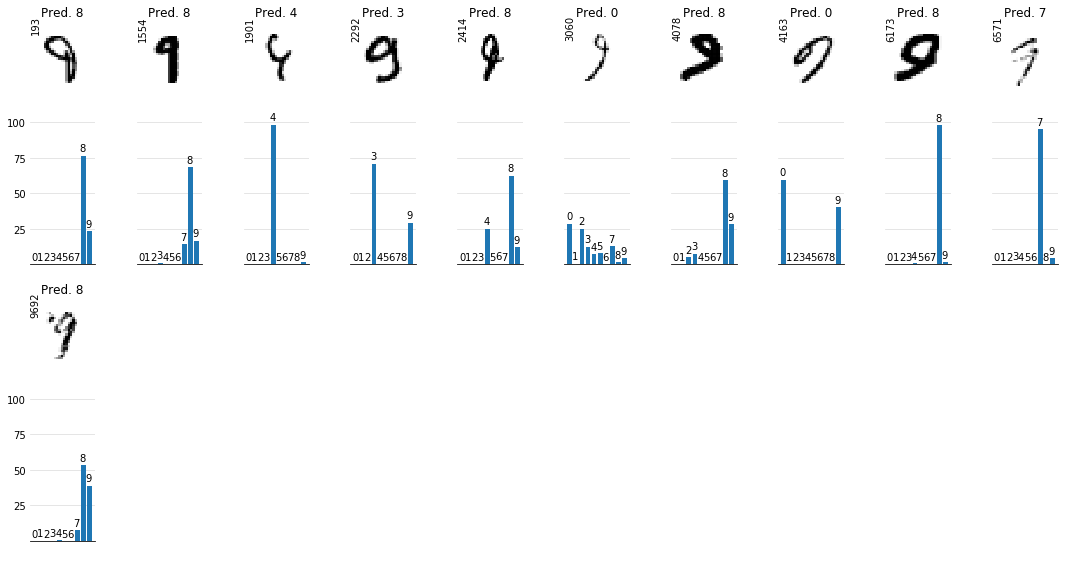

In [26]:
# Get indices of all misclassified instances
all_misclassified_indices = [i for i in np.arange(len(predicted_class)) 
                             if predicted_class[i] != actual_class_label[i]]

# Sanity check - must match the confusion matrix above
assert len(all_misclassified_indices) == sum(conf_mx_misclassifications.sum(axis=0))
print('Found {} misclassified instances'.format(len(all_misclassified_indices)))

# Show each class (digit) separately
for digit in range(NUM_CLASSES):
    print('\n\nMisclassified {}s'.format(digit))
    digit_misclassified_indices = [i for i in all_misclassified_indices if actual_class_label[i] == digit]
    draw_digits(digit_misclassified_indices)

The graphs show that frequently when the predicted class is wrong, the network is almost certain of that (wrong) prediction. In only a few cases (example: misclassified 2, instance 2462), the network missed the correct class by a small margin.

From that observation we can conclude that digits seem to be driven by a small set of discriminating feaures ("2s have a horizontal line towards the bottom", "4s have a top loop that is not quite closed". etc.)

A few new directions to improve the accuracy:

* Perform dimensionality reduction to reduce the number of features the network attempts to learn. It would then have to learn more important features. For example, the 9s misclassified as 4 seem to fall into the category "top loop not quite closed", which seems to be a strong discriminator for 4 in this network. Reducing dimensions may make that "feature" disappear, reducing the confusion.
* Train significantly different networks and create an ensemble. Other network types, e.g. a k-NN classifier or a SVM classifier, could learn features that are significantly different, helping identify the cases this network missed.

### Prediction probabilities

TODO: review examples

The network first predicts the probability for each, then feeds it into the softmax layer to choose a class (the one with highest probability).

Inspecting these probabilities allows us to see how sure (or not) the network is when it misclassified the digits in the above section.

This a 9 that was predicted as 7. For a human it does look like a nine. For the network, it was a close miss. The probability for 9 was just a bit under the probability for 7.

Predicted class: 1, actual class: 1


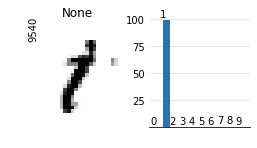

In [27]:
digit_index = 9540
print('Predicted class: {}, actual class: {}'.format(predicted_class[digit_index], actual_class_label[digit_index]))
f, ax = plt.subplots(1, 2, figsize=(4, 2))
draw_one_digit(ax[0], digit_index, original_x_test)
draw_prediction_histogram(ax[1], predicted_probability[digit_index], False)
